## <center>ТЕСТОВОЕ ЗАДАНИЕ</center>


В настоящем задании, вы получаете доступ к набору данных о стоимости недвижимости в различных районах штата Калифорния, США. 

Данные хранятся в реляционной БД в виде двух таблиц:

**neighborhoods** - случайная выборка районов штата Калифорния. Каждая строка таблицы представляет собой какой-то район, имеющий такие атрибуты, как:

    - id - уникальный идентификатор, primary key;
    - longitude - географическая долгота, град.;
    - latitude - географическая широта, град.;
    - median_house_value - медианная стоимость жилого дома в данном районе, доллар США;
    - population - численность населения района, чел.;
    - ocean_proximity - кластер по принципу близости к океану, качественная переменная;
    
**cluster_mean_values** - каждая строка данной таблицы представляет собой кластер районов, сгруппированных по принципу близости к океану. Атрибуты:
    
    - ocean_proximity_cluster - кластер по принципу близости к океану, качественная переменная;
    - mean_median_house_value - среднее значение медианной стоимости жилого дома во ВСЕХ районах данного кластера, доллар США;
    
**ОБРАТИТЕ ВНИМАНИЕ**: **mean_median_house_value** - значение для всей генеральной совокупности районов в кластере. Таблица **neighborhoods**, в свою очередь, содержит только ВЫОБРКИ из каждого кластера, но не ген. совокупности. Если вы посчитаете среднее арифметическое **median_house_value** - это будет ВЫБОРОЧНЫМ значением.
***************************************
  
  
**ВАШИ ЗАДАЧИ:**

1) Извлечь таблицу **neighborhoods** в датафрейм. В части записей отсутствуют данные в атрибуте **ocean_proximity** (null-значения), их необходимо восстановить. Фактически, это задача классификации. Проведите разведочный анализ, подумайте, как в принципе её возможно решить;
    
2) Исправить null-значения **ocean_proximity** в самой БД. Условие: нельзя заменять таблицу в БД на новую, только через обновление значений с помощью SQL;
    
3) С помощью SQL создать объединенный датасет со значениями из двух таблиц БД, т.е. чтобы у каждого района было известно среднее арифметическое медианной стоимости жилья для районов в его кластере. Условие: только с помощью SQL, не с помощью Python; 
    
4) Определить форму распределения **median_house_value** в каждом кластере. Определить выборочные средние **median_house_value** и их отклонения от средних ген. совокупностей. Все изобразить графически для каждого кластера. В виде комментария описать ваши выводы о репрезентативности выборок;
    
5) Определить зависимость стоимости жилья от численности населения района в каждом кластере. Описать в виде комментария;

P.S. Каждое задание необходимо сопроводить комментариями, в которых вы поясняете, чего конкретно добиваетесь и почему используете именно выбранный способ решения. Обоснуйте ваши действия и сформулируйте выводы.

# Solution

## task 1

1) Извлечь таблицу neighborhoods в датафрейм. В части записей отсутствуют данные в атрибуте ocean_proximity (null-значения), их необходимо восстановить. Фактически, это задача классификации. Проведите разведочный анализ, подумайте, как в принципе её возможно решить

In [4]:
import sqlalchemy
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
engine = create_engine('sqlite:///test_project.db')

вспомогательная функция для выполнения sql запросов

In [6]:
def select(sql):
  return pd.read_sql(sql,engine)

In [7]:
sql = '''SELECT *
        FROM neighborhoods
        ;
'''
select(sql)

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,None


запись таблицы в pandas

In [8]:
df = pd.read_sql_table(
    'neighborhoods',
    con=engine
)

In [9]:
df.describe()

,id,longitude,latitude,median_house_value,population
count,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000
mean,8106.000000,-119.563455,35.624790,207457.124591,1430.090236
std,4680.434293,2.001636,2.131828,115450.627025,1156.503275
min,0.000000,-124.350000,32.540000,14999.000000,3.000000
25%,4053.000000,-121.790000,33.930000,120400.000000,786.000000
50%,8106.000000,-118.480000,34.250000,180000.000000,1165.000000
75%,12159.000000,-118.010000,37.710000,265700.000000,1727.000000
max,16212.000000,-114.310000,41.950000,500001.000000,35682.000000


In [10]:
df = df.drop('id',axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16213 entries, 0 to 16212
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16213 non-null  float64
 1   latitude            16213 non-null  float64
 2   median_house_value  16213 non-null  float64
 3   population          16213 non-null  float64
 4   ocean_proximity     11200 non-null  object 
dtypes: float64(4), object(1)
memory usage: 633.4+ KB


Количество пропущенных значений по каждому столбцу

In [12]:
df.isnull().sum()

longitude                0
latitude                 0
median_house_value       0
population               0
ocean_proximity       5013
dtype: int64

Количество дубликатов в датасете

In [13]:
df.duplicated().sum()

0

In [14]:
sns.set_theme(style="darkgrid")

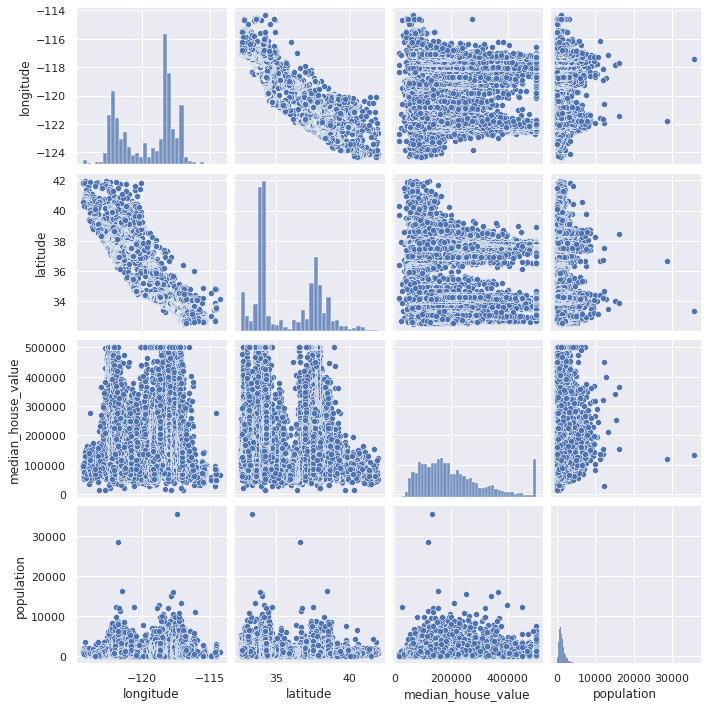

In [15]:
sns.pairplot(data=df)

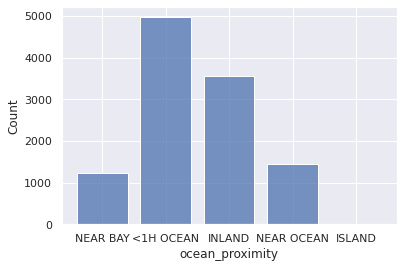

In [16]:
sns.histplot(df.ocean_proximity, shrink=.8)

Разделение средней цены за дом на 5 категорий

In [17]:
df['median_house_value_bin'] = pd.qcut(df['median_house_value'], 5, duplicates='drop')

Построение карты распределения домов, в зависимости от численности, стоимости и близости к океану

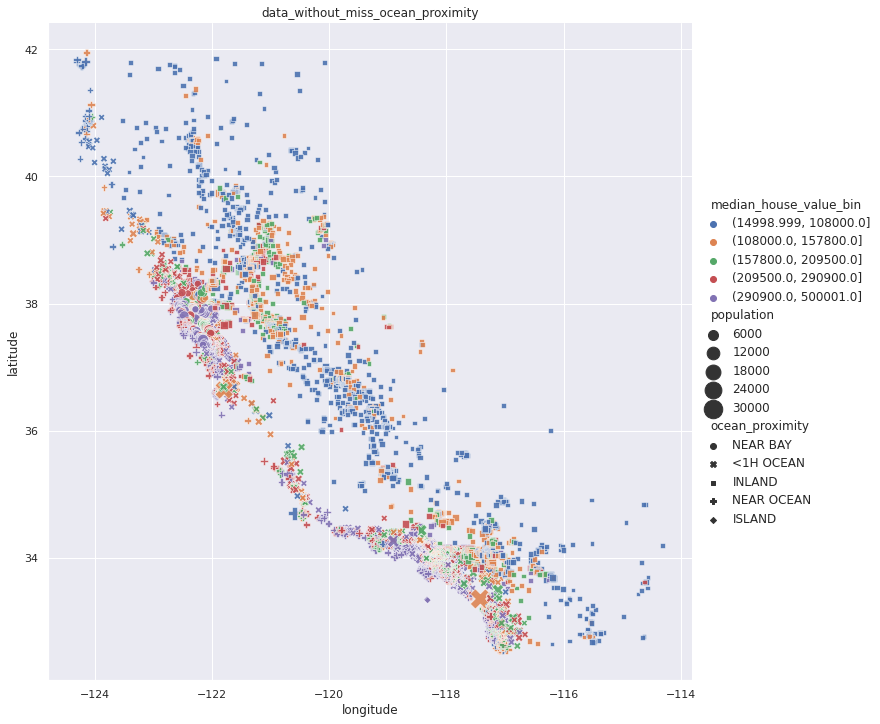

In [18]:
sns.relplot(x="longitude", y="latitude", hue="median_house_value_bin", size="population",style="ocean_proximity",
            sizes=(40, 400), alpha=0.9,
            height=10, data=df[~df['ocean_proximity'].isna()]).set(title='data_without_miss_ocean_proximity')

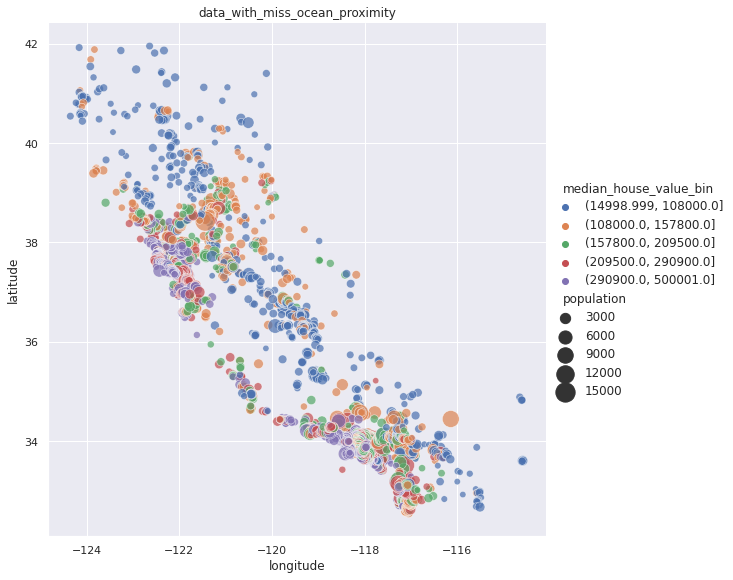

In [19]:
sns.relplot(x="longitude", y="latitude", hue="median_house_value_bin", size="population",
            sizes=(40, 400), alpha=0.7,
            height=8, data=df[df['ocean_proximity'].isna()]).set(title='data_with_miss_ocean_proximity')

Как видим, данные удалили случайным образом, потому что присутвуют пропуски как среди дорогих домов, так и дешевых с разной численностью людей.  

Обновляем таблицу, так как был добавлен столбец, который разбивает цену домов на 5 категорий

In [20]:
df = pd.read_sql_table(
    'neighborhoods',
    con=engine
)

Конвертируем категориальный признак ocean_proximity в числовые значения

In [21]:
# converting categorical values into numerical values
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [22]:
encoder.fit(df[~df['ocean_proximity'].isna()].ocean_proximity)

LabelEncoder()

In [23]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

Выбираем строки в таблице, которые не имеют значение None. И записываем в новый датафрейм, который в дальнейшем будем использовать для обучения

In [24]:
data = df[~df['ocean_proximity'].isna()]

In [25]:
data['ocean_proximity'] = encoder.fit_transform(data['ocean_proximity'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
data.head(5)

,id,longitude,latitude,median_house_value,population,ocean_proximity
1,1,-122.22,37.86,358500.0,2401.0,3
2,2,-122.24,37.85,352100.0,496.0,3
4,4,-122.25,37.85,342200.0,565.0,3
5,5,-122.25,37.85,269700.0,413.0,3
8,8,-122.26,37.84,226700.0,1206.0,3


Чтобы проверить качество выбранной модели, разобъем датасет на train, test

In [27]:
from sklearn.model_selection import train_test_split
X = data.drop(['ocean_proximity','id'], axis=1)  
y = data['ocean_proximity'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state = 666, stratify=y)

Так как данные в таблице имеют различные величины измерения будем использовать StandardScaler

In [28]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


Случайный лес это ансамблевый метод,который имеет плюсы:
*   маленькая дисперсия, чем одно дерево решений
*   не требуется масштабирование данных
 
  для оценки классификации будем использовать f1 меру


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [30]:
y_pred = rfc.predict(X_test_scaled)

In [31]:
from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                                                     index = ['actual 0', 'actual 1','actual 2','actual 3','actual 4'], 
                                                     columns = ['predicted 0', 'predicted 1','predicted 2','predicted 3','predicted 4',])


Матрица ошибок, модель ошибается в 0, 1, 4 классе

In [32]:
display(conf_matrix_baseline)

,predicted 0,predicted 1,predicted 2,predicted 3,predicted 4
actual 0,2442,21,0,2,19
actual 1,38,1733,0,3,0
actual 2,0,0,0,0,1
actual 3,2,3,0,601,14
actual 4,43,0,0,8,670


In [33]:
f1_score(y_test, y_pred, average='micro')

0.9725

В задании не указано допустимое качество модели, поэтому оптимизацию гиперпараметров не буду делать)

Меня полностью устраивает качество модели, поэтому в дальнейшем будем предсказывать пропушенные значния

In [34]:
X_scaled = ss.fit_transform(X)
rfc.fit(X_scaled, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


RandomForestClassifier()

In [35]:
X_none = df[df['ocean_proximity'].isna()].drop(['ocean_proximity','id'],axis=1)
X_scaled_none = ss.fit_transform(X_none)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


In [36]:
y_pred_none = rfc.predict(X_scaled_none)

In [37]:
y_pred_df = pd.DataFrame(y_pred_none,columns=['ocean_proximity'])

In [38]:
df1 = df[df['ocean_proximity'].isna()].drop('ocean_proximity',axis=1)
df2 = df[~df['ocean_proximity'].isna()]

In [39]:
df1 = df1.reset_index()

In [40]:
df1['ocean_proximity']= y_pred_df
df1 = df1.drop('index',axis=1)

In [41]:
df1.ocean_proximity = encoder.inverse_transform(df1.ocean_proximity)

In [42]:
df_res = pd.concat([df1,df2]).sort_values(by=['id'])

В результате имеем таблицу с восстановленными пропусками, с помощью случайного леса решена задача классификации с f1 = 0.97

In [43]:
df_res # восстановленная таблица

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,NEAR BAY
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
1,3,-122.25,37.85,341300.0,558.0,NEAR BAY
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
5012,16211,-121.32,39.43,84700.0,741.0,INLAND


## task 2

2) Исправить null-значения ocean_proximity в самой БД. Условие: нельзя заменять таблицу в БД на новую, только через обновление значений с помощью SQL;

Записываем новую таблицу(result_data) в БД, с помощью которой будем заменять значения None в таблице (neighborhoods) на новые значения по id строки

In [44]:
df_res.to_sql('result_data', engine,if_exists =  'replace')

проверка пропусков в таблице neighborhoods

In [45]:
sql = '''SELECT *
        FROM  neighborhoods  
        ;
'''
select(sql)

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,None


Обновление значений None в neighborhoods

In [46]:
sql = '''
UPDATE neighborhoods 
SET ocean_proximity =
    (SELECT ocean_proximity
     FROM result_data
     WHERE neighborhoods.id = result_data.id)
WHERE ocean_proximity IS NULL;
'''
select(sql)

ResourceClosedError: ignored

Результат

In [47]:
sql = '''SELECT *
        FROM  neighborhoods  
        ;
'''
select(sql)

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,NEAR BAY
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,NEAR BAY
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,INLAND


## task 3

3) С помощью SQL создать объединенный датасет со значениями из двух таблиц БД, т.е. чтобы у каждого района было известно среднее арифметическое медианной стоимости жилья для районов в его кластере. Условие: только с помощью SQL, не с помощью Python;

Добавим дополнительный столбец "mean_median_house_value" в таблицу "neighborhoods" и установим всего его значения нулями

In [48]:
sql = '''
  ALTER TABLE neighborhoods 
  ADD COLUMN mean_median_house_value FLOAT NOT NULL DEFAULT 0
'''
select(sql)

ResourceClosedError: ignored

По аналогии с прошлым заданием, обновим все значения столбца "mean_median_house_value", на значения из другой таблицы, которые совпадают по названию района

In [49]:
sql = '''
  UPDATE neighborhoods
  SET mean_median_house_value = 
  (SELECT cluster_mean_values.mean_median_house_value
  FROM cluster_mean_values   
  WHERE neighborhoods.ocean_proximity = cluster_mean_values.ocean_proximity_cluster
  );
'''
select(sql)


ResourceClosedError: ignored

Результат

In [50]:
sql = '''
  SELECT *
  FROM neighborhoods  

'''
select(sql)

,id,longitude,latitude,median_house_value,population,ocean_proximity,mean_median_house_value
0,0,-122.23,37.88,452600.0,322.0,NEAR BAY,259212.31
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY,259212.31
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY,259212.31
3,3,-122.25,37.85,341300.0,558.0,NEAR BAY,259212.31
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY,259212.31
...,...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND,124805.39
16209,16209,-121.21,39.49,77100.0,356.0,INLAND,124805.39
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND,124805.39
16211,16211,-121.32,39.43,84700.0,741.0,INLAND,124805.39


## task 4

4) Определить форму распределения **median_house_value** в каждом кластере. Определить выборочные средние **median_house_value** и их отклонения от средних ген. совокупностей. Все изобразить графически для каждого кластера. В виде комментария описать ваши выводы о репрезентативности выборок;

In [51]:
import scipy
from scipy import stats
from scipy.stats import kstest
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
from scipy.stats import mannwhitneyu

In [52]:
df_task4 = pd.read_sql_table(
    'neighborhoods',
    con=engine
)

Опираясь на ЦПТ (центральная предельная теорема), утверждаем что все выборки по кластерам распределены по нормальному закону

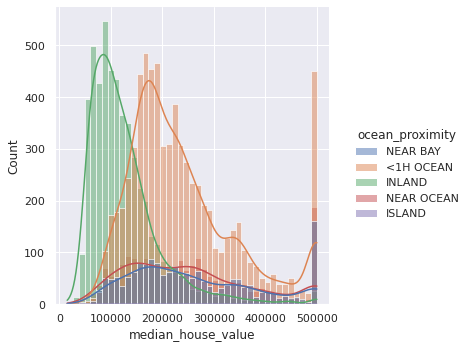

In [53]:
sns.displot(data=df_task4, x="median_house_value", palette='deep', hue="ocean_proximity", kde=True)

Описательная статистика по кластерам

In [54]:
agg_func = {'median_house_value': ['describe']}
df_task4.groupby(['ocean_proximity']).agg(agg_func)

median_house_value                                          \
                          describe                                           
                             count           mean            std       min   
ocean_proximity                                                              
<1H OCEAN                   7210.0  240450.641470  106437.134450   17500.0   
INLAND                      5153.0  125836.293421   70947.288740   14999.0   
ISLAND                         3.0  334066.666667   70109.652212  287500.0   
NEAR BAY                    1751.0  258012.990862  121886.707989   22500.0   
NEAR OCEAN                  2096.0  252211.769561  122770.216892   22500.0   

                                                         
                                                         
                      25%       50%       75%       max  
ocean_proximity                                          
<1H OCEAN        163900.0  214650.0  290275.0  500001.0  
INLAND            78600.0  109400.0  150000.0  500001.0  
ISLAND           293750.0  300000.0  357350.0  414700.0  
NEAR BAY         162500.0  231700.0  342000.0  500001.0  
NEAR OCEAN       152975.0  234350.0  327375.0  500001.0

In [55]:
agg_func = {'median_house_value': ['describe']}
df_task4_describe = df_task4.groupby(['ocean_proximity']).agg(agg_func)

Для подтверждения о нормальности распределения, буду использовать критерий Колмогорова-Смирнова для проверки гипотезы о нормальности распределения. Установим уровень статистической значимости alpha = 0.05 

*   H0 гипотеза - выборка распределена по нормальному закону
*   Н1 гипотеза - иной закон распределения



Вспомогательная функция для сравнения p_val с alpha

In [56]:
def check_p_val(p_val, alpha):
    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')

ocean_proximity = NEAR BAY___________________________________
KS-Test normal distribution test:
Statistics=0.09, p=0.0
We have evidence to reject the null hypothesis.

T-Test comparison of median_house_value and mean_median_house_value:
T-value  [-0.41173851]
P-value  [0.68058152]
We do not have evidence to reject the null hypothesis.

ocean_proximity = <1H OCEAN___________________________________
KS-Test normal distribution test:
Statistics=0.11, p=0.0
We have evidence to reject the null hypothesis.

T-Test comparison of median_house_value and mean_median_house_value:
T-value  [0.29226203]
P-value  [0.7700947]
We do not have evidence to reject the null hypothesis.

ocean_proximity = INLAND___________________________________
KS-Test normal distribution test:
Statistics=0.12, p=0.0
We have evidence to reject the null hypothesis.

T-Test comparison of median_house_value and mean_median_house_value:
T-value  [1.0430671]
P-value  [0.29696616]
We do not have evidence to reject the null hypo

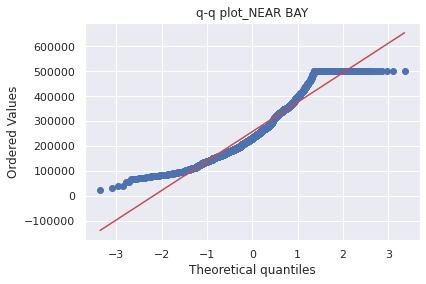

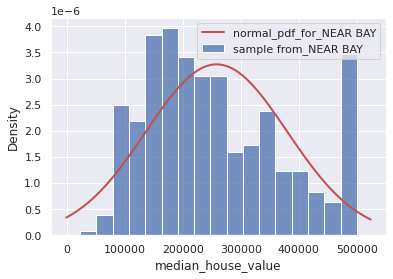

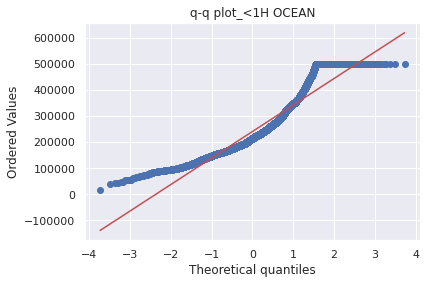

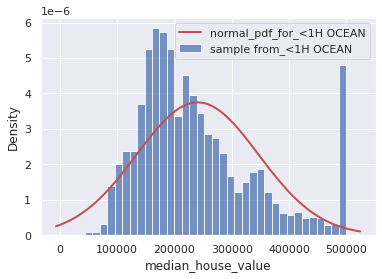

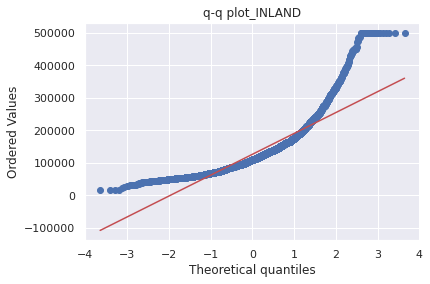

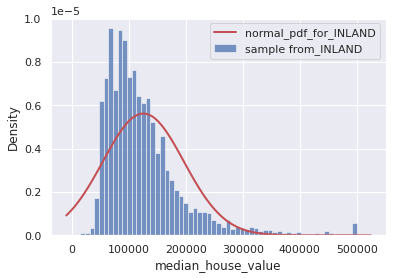

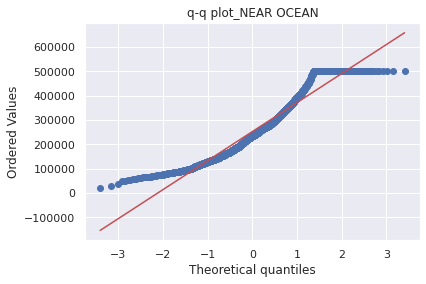

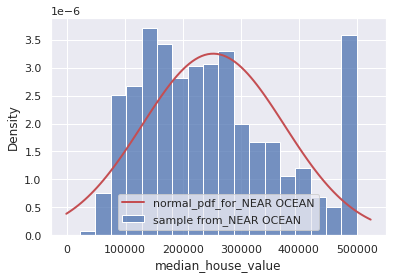

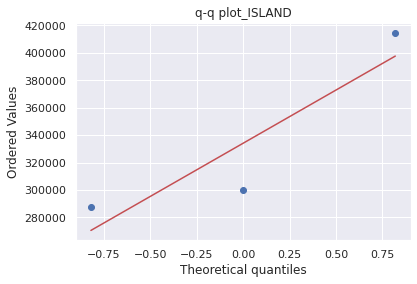

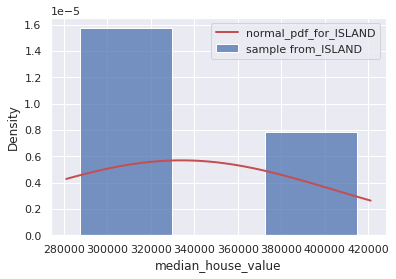

In [57]:
for ocean_proximity in df_task4['ocean_proximity'].unique():
  print(f"ocean_proximity = {ocean_proximity}___________________________________")
  house_value = df_task4.loc[(df_task4["ocean_proximity"] == ocean_proximity) ]
  
  loc = df_task4_describe.loc[ocean_proximity].iloc[1]   # mean value 
  scale = df_task4_describe.loc[ocean_proximity].iloc[2] # std value 
  
  
  #Используем тест Колмогорова-Смирнова 
  stat, p_val = kstest(house_value["median_house_value"].values, 'norm',args=(loc, scale))
  print('KS-Test normal distribution test:')
  print(f'Statistics={np.around(stat,2)}, p={np.around(p_val,2)}')
  check_p_val(p_val, alpha=0.05)


  """ Поскольку p_value < alpha о нормальности распределения нельзя говорить, поэтому использовать 
  т-тест нельзя использовать, по ЦПТ у нас должно быть нормальное распределение.

  """

  m_house = house_value["median_house_value"].values                         # median_house_value
  mm_house_t = house_value["mean_median_house_value"].drop_duplicates().values # mean_median_house_value  
 

  # Run  t-test
  t_val, p_val = ttest_1samp(m_house, mm_house_t)
  # Check the results of the t-test
  print()
  print('T-Test comparison of median_house_value and mean_median_house_value:')
  print(f'T-value  {t_val}')
  print(f'P-value  {p_val}')
  check_p_val(p_val, alpha=0.05)
  print()

  # Построение Q Q графиков для нормальности
  plt.figure()
  stats.probplot(m_house, dist="norm", plot=plt)
  plt.title(f'q-q plot_{ocean_proximity}')

  # Построение графиков
  plt.figure()
  ax = sns.histplot(data=house_value,x="median_house_value", kde=False, 
                    stat='density', label=f'sample from_{ocean_proximity}')

  # calculate the pdf
  x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
  x_pdf = np.linspace(x0, x1, 100)
  y_pdf = scipy.stats.norm.pdf(x_pdf, loc, scale)

  ax.plot(x_pdf, y_pdf, 'r', lw=2, label=f'normal_pdf_for_{ocean_proximity}')                                                   
  ax.legend()

По результатам 4 задания:  

*   для региона - остров мало количество наблюдений, их 3
*   стат-тесты на нормальность распределений не прошли все, кроме распределения для острова
*   т-тест прошли все регионы, это определяет вероятность того, что две выборки взяты из генеральных совокупностей, которые имеют одно и то же среднее.
*   но т-тест применяется для нормальных распределений, я честно проверял другие распределения, но p_value для них был около 0, как и для нормального

*   Дополнительно построил Q-Q, потому что p_value не говорит о бимодальном распределении






## task 5

5) Определить зависимость стоимости жилья от численности населения района в каждом кластере. Описать в виде комментария;




Население не коррелирует со стоимостью дома. В дальнейшем продемонстрирую лучше способ поиска корреляции, чем корреляция Пирсона  [phik correlation](https://arxiv.org/abs/1811.11440)

In [58]:
df_task4.groupby(['ocean_proximity'])[['median_house_value','population']].corr()

median_house_value  population
ocean_proximity                                                   
<1H OCEAN       median_house_value            1.000000   -0.077790
                population                   -0.077790    1.000000
INLAND          median_house_value            1.000000    0.048450
                population                    0.048450    1.000000
ISLAND          median_house_value            1.000000    0.926165
                population                    0.926165    1.000000
NEAR BAY        median_house_value            1.000000    0.004109
                population                    0.004109    1.000000
NEAR OCEAN      median_house_value            1.000000   -0.028124
                population                   -0.028124    1.000000

In [59]:
! pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 5.2 MB/s 


In [60]:
import phik
from phik.report import plot_correlation_matrix

Как видно по результатам матрицы корреляции phik, население ни с чем не коррелирует

interval columns not set, guessing: ['id', 'longitude', 'latitude', 'median_house_value', 'population', 'mean_median_house_value']


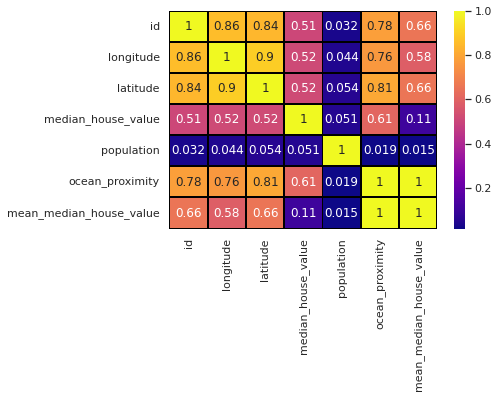

In [61]:
phik_matrix = df_task4.phik_matrix()
sns.heatmap(phik_matrix, annot = True, cmap ='plasma',
            linecolor ='black', linewidths = 1)